##### Copyright 2019 CCBR, IIT Madras.

# Train a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.

https://blog.keras.io/building-autoencoders-in-keras.html

![alt text](https://cdn-images-1.medium.com/max/1600/1*V_YtxTFUqDrmmu2JqMZ-rA.png)
https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f

**Step 0**: imports

In [ ]:
%tensorflow_version 1.x
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as heir
from PIL import Image

print(tf.__version__)

1.15.0


Enable *eager*

In [ ]:
tf.enable_eager_execution()

## Step 1a: define the AutoEncoder architecture
convolutional auto-encoder

In [ ]:
class Downsample(keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(Downsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 

Define the **Encoder** 


In [ ]:
class Encoder(keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = Downsample(32,3, apply_batchnorm=False)
    self.down2 = Downsample(64,3)
    self.flat = keras.layers.Flatten()
    self.fc = keras.layers.Dense(16)
    
  def call(self, x, training):
    x1 = self.down1(x, training=training)
    x2 = self.down2(x1, training=training)
    x3 = self.flat(x2)
    x4 = self.fc(x3)
    return x4
    

Define the **Decoder** 

In [ ]:
class Upsample(keras.Model):
    
  def __init__(self, filters, size, apply_dropout=False):
    super(Upsample, self).__init__()
    self.apply_dropout = apply_dropout
    initializer = tf.random_normal_initializer(0., 0.02)

    self.up_conv = keras.layers.Conv2DTranspose(filters, 
                                                   (size, size), 
                                                   strides=2, 
                                                   padding='same',
                                                   kernel_initializer=initializer,
                                                   use_bias=False)
    self.batchnorm = keras.layers.BatchNormalization()
    if self.apply_dropout:
        self.dropout = keras.layers.Dropout(0.5)

  def call(self, x1, training):
    x = self.up_conv(x1)
    x = self.batchnorm(x, training=training)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = tf.nn.relu(x)
    return x


In [ ]:
class Decoder(keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.fc = keras.layers.Dense(7*7*64)
    self.reshape = keras.layers.Reshape((7,7,64))
    self.up1 = Upsample(64,3, apply_dropout=True)
    self.up2 = Upsample(32,3)
    
    self.collapse = keras.layers.Conv2DTranspose(filters = 1, kernel_size=3,
                                                padding='same',
                                                kernel_initializer=initializer)
    
    self.sigmoid = keras.layers.Activation('sigmoid')
    
  def call(self,x,training):
    
    x = self.reshape(self.fc(x))
    x = self.up1(x, training = training)
    x = self.up2(x, training = training)
    x = self.sigmoid(self.collapse(x))
        
    return x  
    

In [ ]:
# Network parameters
input_shape = (28, 28, 1)


kernel_size = 3

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

latent_dim = 16

**Combine** the encoder and decoder into a single model

In [ ]:
class AutoEncoder(keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    
    self.enc = Encoder()
    self.dec = Decoder( )
    
  @tf.contrib.eager.defun
  def call(self,x, training):
    x1 = self.enc(x, training=training)
    x2 = self.dec(x1, training=training)
    return x2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Step 1b: Compile the model

In [ ]:
autoencoder = AutoEncoder()

encoder = Encoder()

optimizer = tf.train.AdamOptimizer()

autoencoder.compile(optimizer=optimizer)

## Step 2a: Load the dataset

In [ ]:
from keras.datasets import mnist, fashion_mnist

Using TensorFlow backend.


In [ ]:
is_fashion_dataset = not True # initially demonstrating on digits, should work for fashion as well


if is_fashion_dataset:
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 

  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

else:
  (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

  class_names = ['zero','one','two','three','four','five','six','seven','eight','nine']


NTRAIN=len(train_labels)

NTEST=len(test_labels)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images.dtype

dtype('uint8')

### Step 2b: Preprocess the data
The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:



We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [ ]:
if train_images.max()>1.0:
  train_images = train_images[:,:,:,np.newaxis] / 255.0

  test_images = test_images[:,:,:,np.newaxis] / 255.0

In [ ]:
train_images.shape

(60000, 28, 28, 1)

### Step 2c: Define data loader
https://www.tensorflow.org/guide/datasets#consuming_numpy_arrays


In [ ]:

dataset_train = tf.data.Dataset.from_tensor_slices((train_images.astype(np.float32),train_labels))

dataset_test = tf.data.Dataset.from_tensor_slices((test_images.astype(np.float32), test_labels))

# without eager, use this

"""
features_ph_train = tf.placeholder(train_images.dtype, train_images.shape)
labels_ph_train = tf.placeholder(train_labels.dtype, train_labels.shape)

dataset_train = tf.data.Dataset.from_tensor_slices((features_ph_train, labels_ph_train))

features_ph_test = tf.placeholder(test_images.dtype, test_images.shape)
labels_ph_test = tf.placeholder(test_labels.dtype, test_labels.shape)

dataset_test = tf.data.Dataset.from_tensor_slices((features_ph_test, labels_ph_test))
"""



'\nfeatures_ph_train = tf.placeholder(train_images.dtype, train_images.shape)\nlabels_ph_train = tf.placeholder(train_labels.dtype, train_labels.shape)\n\ndataset_train = tf.data.Dataset.from_tensor_slices((features_ph_train, labels_ph_train))\n\nfeatures_ph_test = tf.placeholder(test_images.dtype, test_images.shape)\nlabels_ph_test = tf.placeholder(test_labels.dtype, test_labels.shape)\n\ndataset_test = tf.data.Dataset.from_tensor_slices((features_ph_test, labels_ph_test))\n'

Define a function to add (white) noise to each image

In [ ]:
def noise_add_tf(inp, targ):
  """ Function to add Gaussian random noise to a image 2dtensor """
  
  noise_factor = 0.5
  noisy = inp + noise_factor * tf.random.normal(inp.shape, dtype=inp.dtype)
  
  noisy = tf.clip_by_value(noisy, 0, 1)
  
  #return tf.cast(noisy, tf.float32), tf.cast(inp, tf.float32)
  return inp, inp

### Step 2d: Transform the dataset 
... from a labeled (image, label) 

to an image pair (noisy image, original image)

In [ ]:
BATCH_SIZE = 128

dataset_train = dataset_train.map(noise_add_tf)

dataset_train = dataset_train.batch(BATCH_SIZE)


dataset_test = dataset_test.map(noise_add_tf)

dataset_test = dataset_test.batch(1)

<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'>
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
downsample (Downsample)      multiple                  288       
_________________________________________________________________
downsample_1 (Downsample)    multiple                  18688     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  50192     
Total params: 69,168
Trainable params: 69,040
Non-trainable params: 128
_________________________________________________________________
Model: "decoder"
____________________________________________

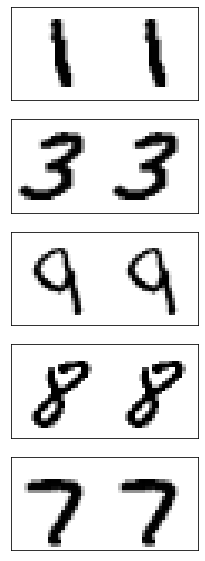

In [ ]:
ii = 0
plt.figure(figsize=(10,10))

if BATCH_SIZE>5:
  randint = np.random.randint(0,BATCH_SIZE-5)
else:
  randint = 0    

for (batch, (inp, target)) in enumerate(dataset_train):
  
  if ii > 4:
    pred=autoencoder(inp,not True)
    
    autoencoder.enc.summary()
    autoencoder.dec.summary()
    autoencoder.summary()
    print(pred.shape)
    break
  print(inp.dtype, target.dtype)
  #print(inp.shape)
  a = inp.numpy()[randint+ii]
  b = target.numpy()[randint+ii]
  #print(a.shape, b.shape)
  plt.subplot(5,1,ii+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.hstack((a[:,:,0],b[:,:,0])),cmap=plt.cm.binary)
  ii = ii + 1
  #break
  
  

## Step 3: Train the model

Create checkpoint directory

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=autoencoder)

Define loss function

In [ ]:
def loss_function(labels, predictions):
  return tf.losses.mean_squared_error(labels, predictions)


Training cycle

In [ ]:
EPOCHS = 5
import time

for epoch in range(EPOCHS):
  start = time.time()
        
  for (batch, (inp, target)) in enumerate(dataset_train):
    with tf.GradientTape() as tape:
      
      #print(inp.shape,target.shape)
      
      prediction = autoencoder(inp,True)
      
      loss = loss_function(target, prediction)
      
      grads = tape.gradient(loss, autoencoder.variables)
      
      optimizer.apply_gradients(zip(grads, autoencoder.variables))
      
      if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                            batch,
                                                            loss))
    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2235
Epoch 1 Batch 100 Loss 0.0374
Epoch 1 Batch 200 Loss 0.0326
Epoch 1 Batch 300 Loss 0.0177
Epoch 1 Batch 400 Loss 0.0163
Epoch 2 Batch 0 Loss 0.0173
Epoch 2 Batch 100 Loss 0.0172
Epoch 2 Batch 200 Loss 0.0158
Epoch 2 Batch 300 Loss 0.0141
Epoch 2 Batch 400 Loss 0.0135
Epoch 3 Batch 0 Loss 0.0148
Epoch 3 Batch 100 Loss 0.0152
Epoch 3 Batch 200 Loss 0.0134
Epoch 3 Batch 300 Loss 0.0129
Epoch 3 Batch 400 Loss 0.0124
Epoch 4 Batch 0 Loss 0.0135
Epoch 4 Batch 100 Loss 0.0140
Epoch 4 Batch 200 Loss 0.0126
Epoch 4 Batch 300 Loss 0.0121
Epoch 4 Batch 400 Loss 0.0119
Epoch 5 Batch 0 Loss 0.0128
Epoch 5 Batch 100 Loss 0.0134
Epoch 5 Batch 200 Loss 0.0123
Epoch 5 Batch 300 Loss 0.0114
Epoch 5 Batch 400 Loss 0.0113
Epoch 5 Loss 0.0146
Time taken for 1 epoch 27.469128608703613 sec



If training was interrupted, restore from checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Step 4: predict on test data

(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


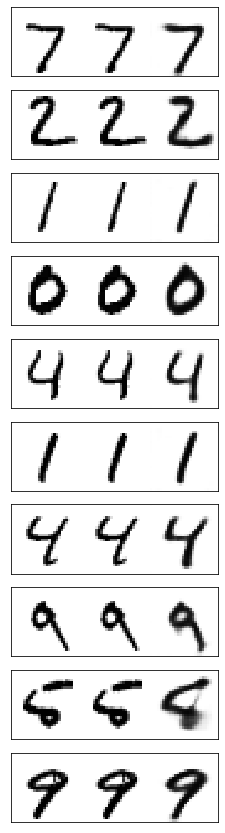

In [ ]:
ii = 0
plt.figure(figsize=(15,15))
  
for (batch, (inp, target)) in enumerate(dataset_test):
  
  if ii >= 10:
    break
    
  pred=autoencoder(inp,not True)
  print(pred.shape)
  
  a = inp.numpy()[0]
  b = target.numpy()[0]
  c = pred.numpy()[0]
  
  #print(a.shape, b.shape)
  plt.subplot(10,1,ii+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.hstack((a[:,:,0],b[:,:,0],c[:,:,0])),cmap=plt.cm.binary)
  ii = ii + 1
  #break

Use the latent space representation to obtain intra and inter class similarity:

(980, 16)
(1135, 16)
(1032, 16)
(1010, 16)
(982, 16)
(892, 16)
(958, 16)
(1028, 16)
(974, 16)
(1009, 16)
     0    1    2    3    4    5    6    7    8    9
0  224  242  245  239  255  235  253  240  236  240
1  242  151  208  207  205  204  207  216  205  199
2  245  208  205  225  227  233  229  229  219  226
3  239  207  225  199  224  214  233  232  219  212
4  255  205  227  224  208  222  232  221  221  205
5  235  204  233  214  222  206  231  221  215  206
6  253  207  229  233  232  231  214  237  223  227
7  240  216  229  232  221  221  237  201  223  204
8  236  205  219  219  221  215  223  223  205  211
9  240  199  226  212  205  206  227  204  211  187


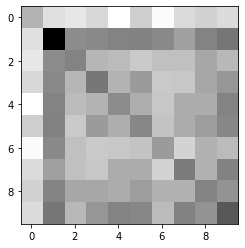

In [ ]:
test_images_encoded = encoder.predict(test_images)
test_labels = test_labels.reshape((10000,1))
test = np.hstack((test_images_encoded, test_labels))
testd = pd.DataFrame(test)
digit = []
for i in range(10):
  testnp = testd[testd[16] == i].values
  digit.append(testnp[:, :-1])
  print(digit[i].shape)
spread = np.zeros((10, 10))
for i in range(10):
  for j in range(10):
    if i!=j:
      temp = dist.cdist(digit[i], digit[j])
    else:
      temp = dist.pdist(digit[i])
    spread[i][j] = np.sum(temp) / np.size(temp)
spread *= 255.0/spread.max()
spread = spread.astype(int)
spreadd = pd.DataFrame(spread)
print(spreadd)
plt.imshow(spread, cmap="gray")
plt.show()